<a href="https://colab.research.google.com/github/GrantCanty/BDT_STC/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting Started

##Import needed modules

In [ ]:
!pip install opencage
!pip install pgeocode
!pip install haversine
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.3 MB/s eta 0:00:00


In [ ]:
import duckdb
from google.colab import drive
import pandas as pd
import calendar
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pgeocode
import time as t
from opencage.geocoder import OpenCageGeocode
import numpy as np
from packaging import version
import tensorflow as tf
import sys
import sklearn.preprocessing as pre

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import networkx
import itertools
import haversine as hs
from haversine import Unit
from pyvis.network import Network
import json
from networkx.readwrite import json_graph

In [ ]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

#Create data warehouse

##Download files

In [ ]:
SHARED_FOLDER_ID = "13rT3mFZ2AKhQe3BOQkAxn8mnN3-kd3Yt"
gdown.download_folder(f'https://drive.google.com/drive/folders/{SHARED_FOLDER_ID}')
conn = duckdb.connect('bdt_project/my_database.db')

Retrieving folder contents


Processing file 15GNjvmlMb9bgIf6VFXlKDoiU-m1oo7Td 1-s2.0-S0303264718301333-main.pdf
Processing file 1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE BDT - Slide report template
Processing file 1GCJjr8yJR23ZWTgM-gX5Z3FFQU42-v70 Borough_And_Community_District_Size.csv
Processing file 1lMDe79IhRHAUN3tMVUgQcBbzqlcF50Gw Borough_And_Community_Zip.csv
Processing file 1OAr8CDu9FRQ62HRzCgvHcvit9Cfpz4Mx DSNY_Frequencies_20250210.csv
Processing file 1ov7qV3Pl1Qx9d4Gt9OGhh-NbQVBP_KMm DSNY_Garages_20250210.csv
Processing file 1e_sRi1MpDGDQApu0641nGqHs0Nyfy-2j DSNY_Monthly_Tonnage_Data.csv
Processing file 1TZ46-LAHdmNyt_ct4XIas9Ab_NlT3GZL DSNY_Special_Waste_Drop-off_Sites_20250204.csv
Processing file 1cXXZSKWFNU2snujiczMLpifFkM5V8Ob_ Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv
Processing file 11Ojm0_1719Oun3Mt-w9HYG1hogL9Dpny lstm_1.weights.h5
Processing file 157qULRjbPksjBJYJE7L5ar0rAFqGhn5r model_architecture.json
Processing file 1-47JasxsUfpjP6NDFrWzRugeXIq_JiZe

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=15GNjvmlMb9bgIf6VFXlKDoiU-m1oo7Td
To: /content/bdt_project/1-s2.0-S0303264718301333-main.pdf
100%|██████████| 2.83M/2.83M [00:00<00:00, 105MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE
From (redirected): https://docs.google.com/presentation/d/1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE/export?format=pptx
To: /content/bdt_project/BDT - Slide report template
265kB [00:00, 511kB/s]
Downloading...
From: https://drive.google.com/uc?id=1GCJjr8yJR23ZWTgM-gX5Z3FFQU42-v70
To: /content/bdt_project/Borough_And_Community_District_Size.csv
100%|██████████| 946/946 [00:00<00:00, 3.38MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lMDe79IhRHAUN3tMVUgQcBbzqlcF50Gw
To: /content/bdt_project/Borough_And_Community_Zip.csv
100%|██████████| 1.20k/1.20k [00:00<00:00, 4.50MB/s

##Make tables

###Make Weather table

In [ ]:
table_name = "weather"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  precipitation FLOAT,
  snow_fall FLOAT,
  snow_depth FLOAT,
  min_temp FLOAT,
  max_temp FLOAT,
);"""
)

In [ ]:
# clear table and load data
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM '/content/bdt_project/NYC_Central_Park_weather_1869-2022.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

###Make tonnage table
mgp tons is metal, glass, plastic


In [ ]:
table_name = "tonnage"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  borough_name STRING,
  community_district STRING,
  refuse_tons DOUBLE,
  paper_tons DOUBLE,
  mgp_tons DOUBLE,
  res_organic_tons DOUBLE,
  school_organic_tons DOUBLE,
  leaves_tons DOUBLE,
  xmas_tree_tons DOUBLE,
  borough_id INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Monthly_Tonnage_Data.csv')

transform.rename(columns={
    'MONTH': 'date',
    'BOROUGH': 'borough_name',
    'COMMUNITYDISTRICT': 'community_district',
    'REFUSETONSCOLLECTED': 'refuse_tons',
    'PAPERTONSCOLLECTED': 'paper_tons',
    'MGPTONSCOLLECTED': 'mgp_tons',
    'RESORGANICSTONS': 'res_organic_tons',
    'SCHOOLORGANICTONS': 'school_organic_tons',
    'LEAVESORGANICTONS': 'leaves_tons',
    'XMASTREETONS': 'xmas_tree_tons',
    'BOROUGH_ID': 'borough_id'
}, inplace=True)

transform['date'] = transform['date'].apply(lambda x: f"{x} / {calendar.monthrange(int(x[:4]), int(x[-2:]))[1]}")
transform['date'] = pd.to_datetime(transform['date'], format='%Y / %m / %d')

transform.to_csv('temp_tonnage_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_tonnage_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make recycling and diversion rates tables

In [ ]:
table_name = "recycling"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  zone STRING,
  district STRING,
  total_diversion_rate FLOAT,
  paper_capture_rate FLOAT,
  mgp_capture_rate FLOAT,
  total_caputre_rate FLOAT,
  date DATE
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Recycling_Diversion_and_Capture_Rates_20250204.csv')

transform.rename(columns={
    'Zone': 'zone',
    'District': 'district',
    'Fiscal Month Number': 'month',
    'Fiscal Year': 'year',
    'Month Name': 'month_name',
    'Diversion Rate-Total (Total Recycling / Total Waste)': 'total_diversion_rate',
    'Capture Rate-Paper (Total Paper / Max Paper)': 'paper_capture_rate',
    'Capture Rate-MGP (Total MGP / Max MGP)': 'mgp_capture_rate',
    'Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100': 'total_caputre_rate'
}, inplace=True)

transform['month'] = transform['month'].apply(lambda x: (x + 6) % 12)
transform['month'] = transform['month'].apply(lambda x: 12 if x == 0 else x)

transform['date'] = transform.apply(lambda x: f"{x['year']}-{x['month']}-{calendar.monthrange(x['year'], x['month'])[1] }", axis=1)
transform['date'] = pd.to_datetime(transform['date'], format='%Y-%m-%d')
transform.drop(columns=['month', 'month_name', 'year'], inplace=True)

transform.to_csv('temp_recycling_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_recycling_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make population table

In [ ]:
table_name = "population"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  CD_Number INTEGER,
  CD_Name STRING,
  Population_1970 INTEGER,
  Population_1980 INTEGER,
  Population_1990 INTEGER,
  Population_2000 INTEGER,
  Population_2010 INTEGER,
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/New_York_City_Population_By_Community_Districts_20250204.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'CD Number': 'CD_Number',
    'CD Name': 'CD_Name',
    '1970 Population': 'Population_1970',
    '1980 Population': 'Population_1980',
    '1990 Population': 'Population_1990',
    '2000 Population': 'Population_2000',
    '2010 Population': 'Population_2010'
}, inplace=True)

transform.to_csv('temp_community_population.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_community_population.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Area Table

In [ ]:
table_name = "area"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  CD_Number INTEGER,
  Square_Miles FLOAT
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Borough_And_Community_District_Size.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'CD Number': 'CD_Number',
    'Square Miles': 'Square_Miles'
}, inplace=True)

transform.to_csv('temp_size.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_size.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Bins table

In [ ]:
table_name = "bins"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  dsny_zone STRING,
  dsny_district VARCHAR,
  site_type STRING,
  site_location VARCHAR,
  partner STRING,
  paper_bins INTEGER,
  mgp_bins INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Public_Recycling_Bins_20250204.csv')

transform.rename(columns={
    'DSNY Zone': 'dsny_zone',
    'DSNY District': 'dsny_district',
    'Site type': 'site_type',
    'Site Location': 'site_location',
    'Partner': 'partner',
    'Paper Bins': 'paper_bins',
    'MGP Bins': 'mgp_bins'
}, inplace=True)

transform.to_csv('temp_public_recycling_bins.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_recycling_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Garages Table

In [ ]:
table_name = "garages"
conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    address STRING,
    boro INTEGER,
    borocd INTEGER,
    city STRING,
    distrtict_code VARCHAR,
    name VARCHAR,
    object_id INTEGER,
    state STRING,
    zip INTEGER,
    longitude FLOAT,
    latitude FLOAT
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Garages_20250210.csv')

#transform.new_column = transform.apply(lambda row: f"POINT({row['longitude']} {row['latitude']})", axis=1)
transform.loc[transform['point'] != ' ', 'longitude'] = ' '
transform.loc[transform['point'] != ' ', 'latitude'] = ' '

def add_lat_and_long(row):
  #print(row['point'][7:-1].split(' '))
  row['longitude'] = row['point'][7:-1].split(' ')[0]
  row['latitude'] = row['point'][7:-1].split(' ')[1]
  #print(long, lat)
  return row

transform = transform.apply(add_lat_and_long, axis=1)

In [ ]:
transform.drop(columns=['BBL', 'BIN', 'TYPE', 'point'], inplace=True)

transform.rename(columns={
    'ADDRESS': 'address',
    'BORO': 'boro',
    'BOROCD': 'borocd',
    'CITY': 'city',
    'DISTRICTCODE': 'distrtict_code',
    'NAME': 'name',
    'OBJECTID': 'object_id',
    'STATE': 'state',
    'ZIP': 'zip',
}, inplace=True)

transform.to_csv('temp_public_garages.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_garages.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Zip Codes table

In [ ]:
table_name = 'zip_codes'

conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  Borough_ID INTEGER,
  CD_Number INTEGER,
  Zip_Code STRING
);""")

In [ ]:
transform = pd.read_csv('/content/bdt_project/Borough_And_Community_Zip.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'Borough_ID': 'Borough_ID',
    'CD Number': 'CD_Number',
    'zip': 'Zip_Code'
}, inplace=True)

transform.to_csv('temp_zips.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_zips.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Location of Dispoal Facilities Tables

In [ ]:
table_name = 'disposal_facilities'

conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    name VARCHAR,
    unique_id INTEGER,
    type STRING,
    address STRING,
    borough STRING,
    state STRING,
    zip INTEGER,
    latitude FLOAT,
    longitude FLOAT
);""")

In [ ]:
transform = pd.read_csv('/content/bdt_project/Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv')
transform.drop(columns=['Point'], inplace=True)

transform.rename(columns={
    'Name': 'address',
    'Unique ID': 'boro',
    'Type': 'borocd',
    'Street Address': 'city',
    'Borough/City': 'distrtict_code',
    'State': 'name',
    'Zipcod': 'object_id',
    'Latitude': 'state',
    'Longitude': 'zip',
}, inplace=True)


transform.to_csv('temp_disposal_facilities.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_disposal_facilities.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

##Data Validation
write a function that checks each column to see if there are missing values

In [ ]:
"""tables = conn.execute("SHOW ALL;").fetchdf()['name']

# Loop through each table
for table_name in tables:
    print(f"📌 Table Name: {table_name}")

    # Get column names and types
    columns_info = conn.execute(f"PRAGMA table_info('{table_name}')").fetchall()
    columns = [col[1] for col in columns_info]  # Column names
    column_types = {col[1]: col[2] for col in columns_info}  # Column name -> Data type

    # Query to count NULL values
    null_query = "SELECT " + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in columns]) + f" FROM {table_name}"
    missing_values = conn.execute(null_query).fetchdf()
    print(missing_values)

    # Fetch full table data
    df = conn.execute(f"SELECT * FROM {table_name}").fetchdf()

    # Loop through numeric columns and plot histograms & boxplots
    for col in columns:
        if column_types[col] in ('INTEGER', 'BIGINT', 'DOUBLE', 'FLOAT', 'DECIMAL'):  # Check if numeric
            print(f"🔹 Plotting distribution for column: {col}")

            # Create figure for plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram with KDE
            sns.histplot(df[col].dropna(), kde=True, ax=axes[0], bins=20, color='blue')
            axes[0].set_title(f"Histogram: {col}")

            # Boxplot
            sns.boxplot(x=df[col].dropna(), ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")

            plt.show()"""

'tables = conn.execute("SHOW ALL;").fetchdf()[\'name\']\n\n# Loop through each table\nfor table_name in tables:\n    print(f"📌 Table Name: {table_name}")\n\n    # Get column names and types\n    columns_info = conn.execute(f"PRAGMA table_info(\'{table_name}\')").fetchall()\n    columns = [col[1] for col in columns_info]  # Column names\n    column_types = {col[1]: col[2] for col in columns_info}  # Column name -> Data type\n\n    # Query to count NULL values\n    null_query = "SELECT " + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in columns]) + f" FROM {table_name}"\n    missing_values = conn.execute(null_query).fetchdf()\n    print(missing_values)\n\n    # Fetch full table data\n    df = conn.execute(f"SELECT * FROM {table_name}").fetchdf()\n\n    # Loop through numeric columns and plot histograms & boxplots\n    for col in columns:\n        if column_types[col] in (\'INTEGER\', \'BIGINT\', \'DOUBLE\', \'FLOAT\', \'DECIMAL\'):  # Check if numer

#Clean Data

##Clean Bins Data

In [ ]:
bins = conn.execute("SELECT * FROM bins").fetchdf()

bins = bins.dropna()

bins.to_csv('temp_bins.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE bins;")
conn.execute(f"COPY bins FROM 'temp_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Weather Data

###Snow Depth Projections
take yesterday's snow depth and add today's snowfall

In [ ]:
weather = conn.execute("SELECT * FROM weather").fetchdf()
weather['snow_fall'] = weather['snow_fall'].fillna(0)
weather['snow_depth_t-1'] = weather['snow_depth'].shift(1)
weather['snow_depth_t-1'] = weather['snow_depth_t-1'].fillna(0)

In [ ]:
weather['snow_depth'] = weather['snow_depth'].fillna(weather['snow_depth_t-1'] + weather['snow_fall'])
weather.drop(columns=['snow_depth_t-1'], inplace=True)

# weather.head(16649)

###Clean Max & Min Missing Temps

do average of future few years for max and min temp. we would look at the past but the missing data is from 1869, the first year when data started being collected. no way to look at past data in this case

In [ ]:
# Ensure that 'date' is in datetime format
weather['date'] = pd.to_datetime(weather['date'])

# Extract the year and month from the 'date' column
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month

# Function to fill missing values using data from the next 3 years for the same month
def fill_missing_with_future_years_mean(row, temp_column):
    # Get the year and month of the row with missing value
    year = row['year']
    month = row['month']

    # Filter data for the next 3 years (including the current row's year)
    future_years_data = weather[(weather['year'] >= year) & (weather['year'] <= year + 2) & (weather['month'] == month)]

    # Calculate the mean of the next 3 years for that month
    mean_value = future_years_data[temp_column].mean() if not future_years_data[temp_column].isnull().all() else None

    return mean_value

# Apply the function to fill missing values for 'max_temp' and 'min_temp'
for idx, row in weather[weather['max_temp'].isnull()].iterrows():
    weather.at[idx, 'max_temp'] = fill_missing_with_future_years_mean(row, 'max_temp')

for idx, row in weather[weather['min_temp'].isnull()].iterrows():
    weather.at[idx, 'min_temp'] = fill_missing_with_future_years_mean(row, 'min_temp')

# drop the 'year' and 'month' columns
weather = weather.drop(columns=['year', 'month'])


# Check the result
#weather.head(124)

make csv file and save csv to database

In [ ]:
weather.to_csv('temp_weather.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE weather;")
conn.execute(f"COPY weather FROM 'temp_weather.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Tonnage Data

In [ ]:
tonnage = conn.execute("SELECT * FROM tonnage").fetchdf()

In [ ]:
tonnage['xmas_tree_tons'] = tonnage['xmas_tree_tons'].fillna(0)
tonnage['leaves_tons'] = tonnage['leaves_tons'].fillna(0)

borough_id
Staten Island = 5, Queens = 4, Brooklyn = 3, Bronx = 2, Manhattan = 1

In [ ]:
tonnage['borough_id'] = tonnage['borough_name'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))

finds rows where there is a missing value for refuse_tons and replaces null value with avg of its borough_id

In [ ]:
missing_vals = tonnage[tonnage['refuse_tons'].isnull()]

for idx, missing_val in missing_vals.iterrows():
    borough_id = missing_val['borough_id']
    community_district = missing_val['community_district']

    mean_refuse_tons = tonnage[tonnage['borough_id'] == 4]['refuse_tons'].mean()

    # Update the original tonnage DataFrame with the mean value for 'refuse_tons'
    tonnage.loc[idx, 'refuse_tons'] = mean_refuse_tons

replace missing school organic tons with 0 if between june and august. else, median of borough_id and community_district

In [ ]:
tonnage['month'] = tonnage['date'].dt.month

# Function to replace missing values based on conditions
def replace_missing_school_organic(row):
    if pd.isnull(row['school_organic_tons']):
        if row['month'] in [6, 7, 8]:  # June, July, August
            return 0
        else:
            # Get the median for the specific borough_id and community_district
            median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) &
                                   (tonnage['community_district'] == row['community_district'])]['school_organic_tons'].median()
            return median_value if pd.notnull(median_value) else 0
    return row['school_organic_tons']

# Apply the function row by row
tonnage['school_organic_tons'] = tonnage.apply(replace_missing_school_organic, axis=1)

In [ ]:
def replace_missing_res_organic(row):
  if pd.isnull(row['res_organic_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['res_organic_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['res_organic_tons']

tonnage['res_organic_tons'] = tonnage.apply(replace_missing_res_organic, axis=1)

In [ ]:
def replace_missing_paper(row):
  if pd.isnull(row['paper_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['paper_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['paper_tons']

tonnage['paper_tons'] = tonnage.apply(replace_missing_paper, axis=1)

In [ ]:
def replace_missing_mgp(row):
  if pd.isnull(row['mgp_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['mgp_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['mgp_tons']

tonnage['mgp_tons'] = tonnage.apply(replace_missing_mgp, axis=1)

In [ ]:
tonnage.drop(columns=['month'], inplace=True)

tonnage.to_csv('temp_tonnage.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE tonnage;")
conn.execute(f"COPY tonnage FROM 'temp_tonnage.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

#Data Processing

##normalize frequency of data
making all data daily frequency so it can be properly ingested by our ml model

###normalize tonnage frequency

gives us the daily rates for each waste type

In [ ]:
tons = conn.execute("SELECT date, borough_name, borough_id, community_district, mode(refuse_tons), mode(paper_tons), mode(mgp_tons), mode(res_organic_tons), mode(school_organic_tons), mode(leaves_tons), mode(xmas_tree_tons) FROM tonnage GROUP BY date, borough_name, borough_id, community_district ORDER BY date, borough_id, community_district").fetchdf()
tons_daily = tons.copy()
tons_daily['date'] = pd.to_datetime(tons_daily['date'])  # Convert to datetime if not already
tons_daily['day'] = pd.to_datetime(tons_daily['date']).dt.day

# poor reporting in earlier data. only using data from 2000 and newer
tons_daily = tons_daily[tons_daily['date'] >= "2000-01-01"]

tons_daily['daily_refuse'] = tons_daily['"mode"(refuse_tons)'] / tons_daily['day']
tons_daily['daily_paper'] = tons_daily['"mode"(paper_tons)'] / tons_daily['day']
tons_daily['daily_mgp'] = tons_daily['"mode"(mgp_tons)'] / tons_daily['day']
tons_daily['daily_res_organic'] = tons_daily['"mode"(res_organic_tons)'] / tons_daily['day']
tons_daily['daily_school_organic'] = tons_daily['"mode"(school_organic_tons)'] / tons_daily['day']
tons_daily['daily_leaves'] = tons_daily['"mode"(leaves_tons)'] / tons_daily['day']
tons_daily['daily_xmas'] = tons_daily['"mode"(xmas_tree_tons)'] / tons_daily['day']

tons_daily.drop(columns=['"mode"(refuse_tons)', '"mode"(paper_tons)', '"mode"(mgp_tons)', '"mode"(res_organic_tons)', '"mode"(school_organic_tons)', '"mode"(leaves_tons)', '"mode"(xmas_tree_tons)'], inplace=True)

In [ ]:
df = tons_daily.copy()
df['date'] = pd.to_datetime(df['date'])

# Extract year & month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Generate full daily date range for each (year, month)
expanded_rows = []
for _, row in df.iterrows():
    start_date = pd.Timestamp(year=row['year'], month=row['month'], day=1)
    end_date = row['date']  # The original month-end date

    # Create a daily date range
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Expand while keeping borough_id & community_id
    for day in daily_dates:
        expanded_rows.append({'date': day, 'borough_id': row['borough_id'], 'community_district': row['community_district']})

# Create new DataFrame
df_daily = pd.DataFrame(expanded_rows)

In [ ]:
# sorting data set by date, then borough_id, then community_district
df_sorted = df_daily.sort_values(by=['date', 'borough_id', 'community_district'])
df_sorted = df_sorted.reset_index(drop=True)

In [ ]:
## working

# Ensure date columns are in datetime format
df_sorted['date'] = pd.to_datetime(df_sorted['date'])
tons_daily['date'] = pd.to_datetime(tons_daily['date'])

# Extract Year and Month for merging
df_sorted['year'] = df_sorted['date'].dt.year
df_sorted['month'] = df_sorted['date'].dt.month
tons_daily['year'] = tons_daily['date'].dt.year
tons_daily['month'] = tons_daily['date'].dt.month

# Perform the merge on matching columns
tonnage_df = df_sorted.merge(
    tons_daily[['year', 'month', 'borough_id', 'community_district', 'date', 'daily_refuse', 'daily_paper', 'daily_mgp', 'daily_res_organic', 'daily_school_organic', 'daily_leaves', 'daily_xmas']],
    on=['year', 'month', 'borough_id', 'community_district'],
    how='left'
)

# Drop any duplicated 'date' columns from the merge (if they exist)
tonnage_df.drop(columns=['date_y'], inplace=True)

# Fill missing daily values (if applicable)
tonnage_df['daily_refuse'] = tonnage_df['daily_refuse'].fillna(0)
tonnage_df['daily_paper'] = tonnage_df['daily_paper'].fillna(0)
tonnage_df['daily_mgp'] = tonnage_df['daily_mgp'].fillna(0)
tonnage_df['daily_res_organic'] = tonnage_df['daily_res_organic'].fillna(0)
tonnage_df['daily_school_organic'] = tonnage_df['daily_school_organic'].fillna(0)
tonnage_df['daily_leaves'] = tonnage_df['daily_leaves'].fillna(0)
tonnage_df['daily_xmas'] = tonnage_df['daily_xmas'].fillna(0)

# Calculate cumulative sums for each category, resetting each month
tonnage_df['refuse'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_refuse'].cumsum()
tonnage_df['paper'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_paper'].cumsum()
tonnage_df['mgp'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_mgp'].cumsum()
tonnage_df['res_organic'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_res_organic'].cumsum()
tonnage_df['school_organic'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_school_organic'].cumsum()
tonnage_df['leaves'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_leaves'].cumsum()
tonnage_df['xmas'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_xmas'].cumsum()

# Drop temporary columns that are no longer needed
tonnage_df.drop(columns=['year', 'month', 'daily_refuse', 'daily_paper', 'daily_mgp',
                         'daily_res_organic', 'daily_school_organic', 'daily_leaves', 'daily_xmas'], inplace=True)

tonnage_df.rename(columns={
    'date_x': 'date'
}, inplace=True)

# Display the result
# tonnage_df


###normalize population data frequency

In [ ]:
populations = conn.execute("SELECT * FROM population").fetchdf()

In [ ]:
area = conn.execute("SELECT * FROM area").fetchdf()

In [ ]:
# add the change in population from each year
df_population_change = pd.DataFrame({
    'Borough': populations['Borough'],
    'community_district': populations['CD_Number'],
    'CD_Name': populations['CD_Name'],
    'Change_1970_1980': populations['Population_1980'] - populations['Population_1970'],
    'Change_1980_1990': populations['Population_1990'] - populations['Population_1980'],
    'Change_1990_2000': populations['Population_2000'] - populations['Population_1990'],
    'Change_2000_2010': populations['Population_2010'] - populations['Population_2000']
})

project the growth from 2000 to 2010 onto the data on a yearly basis. growth continues after 2010 as we have no newer values to use

In [ ]:
df_population = populations.copy()

df_population['Change_2000_2010'] = df_population['Population_2010'] - df_population['Population_2000']

# Calculate the annual growth rate (growth per year between 2000 and 2010). keep using this factor for growth after 2010 as well
df_population['Annual_Growth_Rate'] = df_population['Change_2000_2010'] / 10

# Set the starting year to 2000 and the target years 2000-2025
start_year = 2000
end_year = 2025

# Create a list to hold the daily projected data
daily_data = []

# Loop through each row of the population DataFrame to project data for each Borough and CD
for _, row in df_population.iterrows():
    # Starting population from 2000
    population_2000 = row['Population_2000']
    growth_rate = row['Annual_Growth_Rate']

    # Loop through each year and calculate the projected population for each day
    for year in range(start_year, end_year + 1):
        # Generate a date range for the current year (January 1 to December 31)
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

        # Calculate the projected population for this year (using the annual growth rate)
        projected_population = population_2000 + (year - start_year) * growth_rate

        # get the value for area of the resulting borough and cd_number
        area_value = area.loc[(area['Borough'] == row['Borough']) & (area['CD_Number'] == row['CD_Number']), 'Square_Miles'].values[0]

        # Create a DataFrame for this year's daily population data
        temp_df = pd.DataFrame({
            'date': date_range,
            'Borough': row['Borough'],
            'community_district': row['CD_Number'],
            'CD_Name': row['CD_Name'],
            'Projected_Population': projected_population,
            'projected_density': projected_population / area_value
        })

        # Append the data to the list
        daily_data.append(temp_df)

# Concatenate all the daily data into one DataFrame
population_df = pd.concat(daily_data, ignore_index=True)

In [ ]:
population_df['borough_id'] = population_df['Borough'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))
population_df.drop(columns=['Borough', "CD_Name"], inplace=True)

##Data Preprocessing Before the Model

In [ ]:
weather_df = conn.execute("SELECT * FROM weather").fetchdf()
weather_df = weather_df[weather_df["date"] >= "2000-01-01"]

In [ ]:
# asserting community_district row in tonnage_df as an int
# necessary to ensure that merge works correctly
print(len(tonnage))
tonnage_df = tonnage_df.dropna()
print(len(tonnage))

tonnage_df['community_district'] = pd.to_numeric(tonnage_df['community_district'], errors='coerce')

print(len(tonnage))
tonnage_df = tonnage_df.dropna()
print(len(tonnage))

tonnage_df['community_district'] = tonnage_df['community_district'].astype(int)

24122
24122
24122
24122


<ipython-input-61-d72f820da649>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tonnage_df['community_district'] = tonnage_df['community_district'].astype(int)


In [ ]:
# merge weather_df and population_df together
df = pd.merge(weather_df, population_df, on=['date'] , how='left')

# merge the result with tonnage_df
df = pd.merge(df, tonnage_df, on=['date', 'borough_id', 'community_district'], how='left')

# Ensure the 'date' column is datetime type
df['date'] = pd.to_datetime(df['date'])

###Data Splitting and Scaling

In [ ]:
# ensure values are sorted properly
df.sort_values('date')

split_date = "2020-01-01"
train_df = df[df['date'] < split_date]

train_df = train_df[train_df['date'] >= "2008-01-01"]
test_df = df[df['date'] >= split_date]

In [ ]:
test_df.to_csv("non_scaled_test.csv")

In [ ]:
scaler = pre.StandardScaler()
scaled_train = scaler.fit_transform(train_df[['borough_id', 'community_district', 'refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas', 'precipitation', 'snow_fall', 'snow_depth', 'max_temp', 'min_temp', 'Projected_Population', 'projected_density']])

scaled_test = scaler.transform(test_df[['borough_id', 'community_district', 'refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas', 'precipitation', 'snow_fall', 'snow_depth', 'max_temp', 'min_temp', 'Projected_Population', 'projected_density']])

In [ ]:
#np.savetxt("temp_scaled_train.csv", scaled_train, delimiter=",")
#np.savetxt('temp_scaled_test.csv', scaled_test, delimiter=",")

In [ ]:
target_cols = ['refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas']

X_train_full = scaled_train
y_train_no_scale = train_df[target_cols].values

X_test_full = scaled_test
y_test_no_scale = test_df[target_cols].values

In [ ]:
y_scaler = pre.StandardScaler()


y_train_reduced = y_scaler.fit_transform(y_train_no_scale)
y_test_reduced = y_scaler.transform(y_test_no_scale)

In [ ]:
y_mean = y_scaler.mean_
y_std = y_scaler.scale_
print(f"Mean: {y_mean}, Std: {y_std}")

Mean: [1862.341449 218.667119 180.291553 33.772147 20.242175 0.695124 1.156125], Std: [1314.639668 187.954391 138.788594 42.238737 25.925356 9.291520 6.146090]


#Make ML Model

###Functions for testing

Sequencing, and Reshaping

In [ ]:
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])  # Input sequence
        y_seq.append(y[i+time_steps])    # Target at future time step
    return np.array(X_seq), np.array(y_seq)

In [ ]:
time_steps = 32

X_train, y_train = create_sequences(X_train_full, y_train_reduced, time_steps)
X_test, y_test = create_sequences(X_test_full, y_test_reduced, time_steps)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(258565, 32, 16)
(258565, 7)
(64514, 32, 16)
(64514, 7)


In [ ]:
# reduce ram usage

X_train = X_train.astype('float16')
y_train = y_train.astype('float16')
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')

In [ ]:
def fit_and_evaluate(model, X_train, y_train, X_test, y_test, learning_rate, epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="mae", optimizer=opt, metrics=["mae"])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                        callbacks=[early_stopping_cb])

    # Evaluate on test set
    valid_loss, valid_mae = model.evaluate(X_test, y_test)

    # Generate predictions
    predictions = model.predict(X_test)

    return valid_mae, predictions

###building model

In [ ]:
target_cols_len = len(target_cols)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(45, return_sequences=True, activation='tanh', input_shape=[X_train.shape[1], X_train.shape[2]]),
    tf.keras.layers.LSTM(15, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(target_cols_len)
])

lstm_model.load_weights("bdt_project/lstm_1.weights.h5")
preds = lstm_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2017/2017 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


In [ ]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 32, 45)              │          11,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 15)                  │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,932 (58.33 KB)

 Trainable params: 14,932 (58.33 KB)

 Non-trainable params: 0 (0.00 B)

###evaluate model

In [ ]:
# size of X_train in bytes
print(X_train.itemsize * X_train.size)

264770560


In [ ]:
# mae, preds = fit_and_evaluate(lstm_model, X_train, y_train, X_test, y_test, .00062, 15)

In [ ]:
# print(f"Validation MAE: {mae}")

In [ ]:
#lstm_model.save_weights("bdt_project/lstm_1.weights.h5")

In [ ]:
test_indices = test_df.reset_index(drop=True).index

# The target for each sequence is from index: i + time_steps
target_indices = test_indices[time_steps:]  # This corresponds to your y_test

# Get borough and community district values for these indices:
metadata = test_df[['borough_id', 'community_district', 'date']].reset_index(drop=True).iloc[time_steps:]
pred_df = pd.DataFrame(preds, columns=target_cols)
pred_df = pd.concat([metadata.reset_index(drop=True), pred_df], axis=1)
print(pred_df.head())

   borough_id  community_district       date    refuse     paper       mgp  \
0           1                   3 2020-01-01 -1.346792 -1.105178 -1.212131   
1           1                   4 2020-01-01 -1.358142 -1.060596 -1.192124   
2           1                   5 2020-01-01 -1.373314 -1.100222 -1.255674   
3           1                   6 2020-01-01 -1.328378 -1.065388 -1.170138   
4           1                   7 2020-01-01 -1.325456 -0.955367 -1.098219   

   res_organic  school_organic    leaves      xmas  
0    -0.790601       -0.718171 -0.074801  0.009099  
1    -0.777133       -0.744224 -0.074790 -0.041275  
2    -0.795108       -0.772141 -0.074789 -0.070894  
3    -0.772680       -0.763949 -0.074818  0.058129  
4    -0.783617       -0.729486 -0.074832  0.166270  


In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# inverse scale the predictions and y_testing values for comparison
pred_df[target_cols] = y_scaler.inverse_transform(pred_df[target_cols])
y_pred_final = pred_df[target_cols]
y_pred_final = y_pred_final.to_numpy()
y_test_final = y_scaler.inverse_transform(y_test)

# print first few results
print(y_pred_final[:5], '\n')
print(y_test_final[:5])

[[91.795303 10.944081 12.061557 0.378181 1.623335 0.000109 1.212046]
 [76.873550 19.323538 14.838382 0.947048 0.947909 0.000212 0.902444]
 [56.928242 11.875493 6.018283 0.187782 0.224142 0.000218 0.720407]
 [116.002823 18.422705 17.889774 1.135120 0.436533 -0.000050 1.513390]
 [119.843887 39.101719 27.871235 0.673137 1.329987 -0.000183 2.178033]] 

[[92.312500 12.414062 11.789062 0.646973 1.742188 -0.000189 0.645508]
 [74.312500 17.546875 14.789062 1.147461 0.757812 -0.000189 0.958008]
 [42.343750 9.539062 6.542969 0.147095 0.007801 -0.000189 0.722656]
 [89.312500 19.921875 15.789062 1.241211 0.007801 -0.000189 1.322266]
 [151.375000 36.781250 27.671875 1.366211 1.601562 -0.000189 2.613281]]


In [ ]:
print(pred_df.shape)
print(y_pred_final.shape)
print(type(y_pred_final))
print(y_test_final.shape)
print(type(y_test_final))


(64514, 10)
(64514, 7)
<class 'numpy.ndarray'>
(64514, 7)
<class 'numpy.ndarray'>


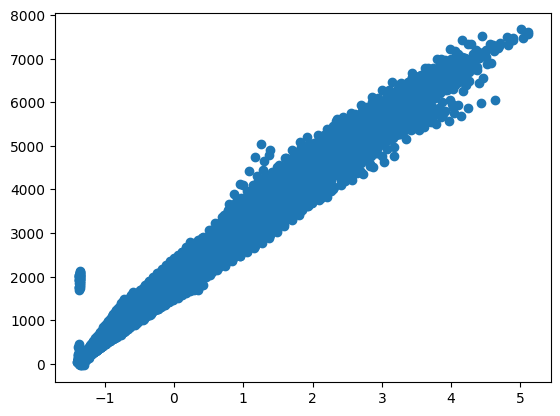

In [ ]:
plt.scatter(y_test[:, 0], y_pred_final[:, 0], label="refuse")

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test_final[:, 0], y_pred_final[:, 0])

0.9887686371803284

#Build a graph

##Processing data to be ready for a graph

###Recycling Bins

Staten Island = 5, Queens = 4, Brooklyn = 3, Bronx = 2, Manhattan = 1

In [ ]:
locations = pd.DataFrame()
recycling_bins = conn.execute("SELECT * FROM bins").fetchdf()

# switch from abreviation to true value
recycling_bins['borough'] = recycling_bins['dsny_zone'].apply(lambda x: 'Manhattan' if x == 'MAN' else ('Bronx' if x == 'BX' else ('Brooklyn' if x == 'BKN' else ('Queens' if x == 'QE' else ('Queens' if x == 'QW' else( 'Staten Island'))))))

# give numeric value for true value
recycling_bins['borough_id'] = recycling_bins['dsny_zone'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))

# clean up address formatting. better for making queries to the address api
recycling_bins['site_location'] = recycling_bins['site_location'].apply(lambda x: x.split(' -')[0])

# drop duplicate values from the dataset
recycling_bins = recycling_bins.drop_duplicates(subset=['site_location'], keep='first')

In [ ]:
OPENCAGE_API_KEY = "596740f709444a94a58777ea23b70c5e"
geocoder = OpenCageGeocode(OPENCAGE_API_KEY)

def get_lat_lon_opencage(address):
    result = geocoder.geocode(address)
    if result:
        return result[0]["geometry"]["lat"], result[0]["geometry"]["lng"]
    print("no result")
    return None


In [ ]:
for index, row in recycling_bins.iterrows():
  point = f"{row['site_location']}, {row['borough']}, NY"

  # clean up address formatting
  point = point.replace('/', ' ')

  # some address start with a letter and then integers. ex: 'b17'. splits up chars and numbers
  match = re.match(r"([a-z]+)([0-9]+)", point, re.I)
  if match:
    # gets chars and numbers
    items = match.groups()
    # split on the character. keep the remainder of the string
    point = point.split(items[0], 1)[1]
  #t.sleep(1)
  location = get_lat_lon_opencage(point)
  # print(f"{location} - {point}")
  if location:
    locations.loc[index, 'latitude'] = location[0]
    locations.loc[index, 'longitude'] = location[1]
    locations.loc[index, 'type'] = 'recycling_bin'

    match = re.match(r"([a-z]+)([0-9]+)", row['dsny_district'], re.I)
    items = match.groups()
    locations.loc[index, 'cd_number'] = int(items[1])

In [ ]:
# dropping duplicates
# duplicates are just a general value for the address. specific address can't be found
locations = locations.drop_duplicates(subset=['latitude', 'longitude'], keep=False)

In [ ]:
locations['borough_id'] = recycling_bins['borough_id']
locations['borough'] = recycling_bins['borough']

<ipython-input-91-02022c336e0f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations['borough_id'] = recycling_bins['borough_id']
<ipython-input-91-02022c336e0f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locations['borough'] = recycling_bins['borough']


###Garages Data

In [ ]:
garages = conn.execute("SELECT * FROM garages").fetchdf()

for index, row in garages.iterrows():
  garages.loc[index, 'borocd'] = (int(str(garages['borocd'][index])[1:]))
  garages.loc[index, 'type'] = 'garage'

garages.rename(columns={'boro': 'borough_id', 'borocd': 'cd_number'}, inplace=True)

###Merge Garages & Recycling Bins

In [ ]:
common_cols = list(set(locations.columns).intersection(garages.columns))
locations_shared = locations[common_cols]
garages_shared = garages[common_cols]

merged = pd.concat([locations_shared, garages_shared], ignore_index=True)
merged['cd_number'] = merged['cd_number'].astype(int)

In [ ]:
# removes outlier
merged = merged[merged['longitude'] >= -75]
merged.reset_index(inplace=True, drop=True)

###Adding points to the graph for waste pick up points

bins_per_comm['bins_needed'] = bins_per_comm['mean(refuse_tons)'] / 800

gives us a manageable amount of bins to explore. if we add too many bins, it takes too long for graph algorithims to be effective

In [ ]:
bins_per_comm = conn.execute("SELECT borough_name, borough_id, community_district, mean(refuse_tons)  from tonnage GROUP BY borough_name, borough_id, community_district ORDER BY borough_id, community_district;").fetchdf()
bins_per_comm['bins_needed'] = bins_per_comm['mean(refuse_tons)'] / 800
bins_per_comm['bins_needed'] = np.ceil(bins_per_comm['bins_needed']).astype(int)

In [ ]:
pred_df_date = pred_df[pred_df['date'] == '2020-01-15'][['borough_id', 'community_district', 'date', 'refuse']]
pred_df_date.reset_index(inplace=True, drop=True)

In [ ]:
# reduce non int values from community_district
bins_per_comm = bins_per_comm.drop(bins_per_comm[bins_per_comm['community_district'] == '7A'].index)
bins_per_comm.reset_index(inplace=True, drop=True)

bins_per_comm['community_district'] = bins_per_comm['community_district'].astype(int)

In [ ]:
zips = conn.execute("SELECT * FROM zip_codes").fetchdf()

In [ ]:
def get_lat_lon_from_zip(zip_code, country="US"):
    nomi = pgeocode.Nominatim(country)
    location = nomi.query_postal_code(zip_code)
    if location.latitude and location.longitude:
        return location.latitude, location.longitude
    else:
        return None

In [ ]:
merged_copy = merged.copy()
merged_copy['waste_amt'] = np.zeros(len(merged_copy))

# go through each row of bins_per_comm, get its borough id, cd_num & bins_needed
# loop through the number of bins needed, find the coordinates of the row's zip code, and add random noise for spacing
# add the coordinates and other data as a new row to the merged_copy
for index, row in bins_per_comm.iterrows():
  borough_id = row['borough_id']
  cd_number = row['community_district']
  bins_needed = row['bins_needed']
  vals = merged[(merged['borough_id'] == borough_id) & (merged['cd_number'] == cd_number)]
  #print(borough_id, cd_number)
  #print(vals)
  waste = pred_df_date[(pred_df_date['borough_id'] == borough_id) & (pred_df_date['community_district'] == cd_number)]['refuse'].values[0] / bins_needed

  for _ in range(bins_needed):
    zip = zips[(zips['Borough_ID'] == borough_id) & (zips['CD_Number'] == cd_number)]['Zip_Code'].values[0]
    coorinates = get_lat_lon_from_zip(zip)
    lat = coorinates[0] + np.random.uniform(-0.02, 0.02)
    lon = coorinates[1] + np.random.uniform(-0.02, 0.02)
    #print(lat, lon)

    merged_copy.loc[len(merged_copy)] = {'borough_id': borough_id, 'type': 'waste_bin', 'cd_number': cd_number, 'longitude': lon, 'latitude': lat, 'waste_amt': waste }

In [ ]:
# copy values from merged_copy back to merged
merged = merged_copy.copy()

In [ ]:
merged.head(455)

,cd_number,longitude,borough_id,type,latitude,waste_amt
0,2,-73.988736,5,recycling_bin,40.689939,0.000000
1,2,-73.988201,5,recycling_bin,40.690874,0.000000
2,2,-73.988580,5,recycling_bin,40.692760,0.000000
3,2,-73.989387,5,recycling_bin,40.693898,0.000000
4,2,-73.973354,5,recycling_bin,40.682831,0.000000
...,...,...,...,...,...,...
450,14,-73.754363,4,waste_bin,40.616015,341.071381
451,1,-74.093383,5,waste_bin,40.640228,310.418876
452,1,-74.097936,5,waste_bin,40.645174,310.418876
453,1,-74.110652,5,waste_bin,40.618464,310.418876


In [ ]:
# if value is above 300, it needs to be picked up
merged['pickup'] = merged['waste_amt'].apply(lambda x: True if x > 300 else(False))

##Graph

###Build the Graph

In [ ]:
G = networkx.Graph()
for i in range(len(merged)):
  G.add_node(i, longitude=merged.loc[i, 'longitude'], latitude=merged.loc[i, 'latitude'], borough=merged.loc[i, 'borough_id'], cd_number=merged.loc[i, 'cd_number'], point_type=merged.loc[i, 'type'], waste_amt=merged.loc[i, 'waste_amt'], pickup=merged.loc[i, 'pickup'])


In [ ]:
# connect vertices as long as they are part of the same borough and are not both garages
for u, v in itertools.combinations(G.nodes, 2):
  if (G.nodes[u]['borough'] == G.nodes[v]['borough'] and not (G.nodes[u]['point_type'] == 'garage' and G.nodes[v]['point_type'] == 'garage')):
        G.add_edge(u, v)
        loc1 = (G.nodes[u]['latitude'], G.nodes[u]['longitude'])
        loc2 = (G.nodes[v]['latitude'], G.nodes[v]['longitude'])
        distance = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)
        G.edges[u, v]['weight'] = distance

In [ ]:
#G.remove_edges_from(list(G.edges()))
G.nodes(data=True)

NodeDataView({0: {'longitude': -73.9887364, 'latitude': 40.6899394, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 1: {'longitude': -73.9882009, 'latitude': 40.6908743, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 2: {'longitude': -73.9885801, 'latitude': 40.6927596, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 3: {'longitude': -73.989387, 'latitude': 40.693898, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 4: {'longitude': -73.9733542, 'latitude': 40.6828309, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 5: {'longitude': -74.00171, 'latitude': 40.64994, 'borough': 5, 'cd_number': 2, 'point_type': 'recycling_bin', 'waste_amt': 0.0, 'pickup': False}, 6: {'longitude': -73.97552, 'latitude': 40.686757, 'borough': 5, 'cd_number': 2, 'poin

In [ ]:
import json
from networkx.readwrite import json_graph

class CustomJSONizer(json.JSONEncoder):
    def default(self, obj):
        return super().encode(bool(obj)) \
            if isinstance(obj, np.bool_) \
            else super().default(obj)

def convert_attributes(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (np.int64, np.float64)):  # Check for NumPy types
                G.nodes[node][key] = value.item()  # Convert to native Python type

    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (np.int64, np.float64)):
                G.edges[u, v][key] = value.item()

# Convert attributes to JSON-safe types
convert_attributes(G)

# Convert graph to JSON-compatible format
graph_data = json_graph.node_link_data(G)

# Save to JSON file
with open("graph.json", "w") as f:
    json.dump(graph_data, f, cls=CustomJSONizer, indent=4)

/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


###Routing

need to add fill vals of each bin, create subset of graph

####routes with just a subset

In [ ]:
borough_nodes_1 = [n for n, data in G.nodes(data=True) if data.get('borough') == 1]
G_borough_1 = G.subgraph(borough_nodes_1)
garages_1 = [n for n, data in G_borough_1.nodes(data=True) if data.get('point_type') == 'garage']
waste_bins_1 = [n for n, data in G_borough_1.nodes(data=True) if data.get('point_type') == 'waste_bin' and data.get('pickup') == True]
print(f'waste bin vertices in borough 1: {len(waste_bins_1)}')

waste bin vertices in borough 1: 36


In [ ]:
points_of_interest = garages_1 + waste_bins_1
pairwise_distances = {}
pairwise_paths = {}

for source in points_of_interest:
    pairwise_distances[source] = {}
    pairwise_paths[source] = {}
    for target in points_of_interest:
        if source != target:
            distance = networkx.shortest_path_length(G, source=source, target=target, weight='weight')
            path = networkx.shortest_path(G, source=source, target=target, weight='weight')
            pairwise_distances[source][target] = distance
            pairwise_paths[source][target] = path

In [ ]:
def nearest_neighbor_tsp(start, nodes, distances):
    tour = [start]
    unvisited = set(nodes)
    unvisited.remove(start)
    current = start

    while unvisited:
        next_node = min(unvisited, key=lambda node: distances[current][node])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    tour.append(start)  # return to start
    return tour

# Example usage:
start_garage = garages_1[0]  # choose a starting garage
points = garages_1 + waste_bins_1
tsp_route = nearest_neighbor_tsp(start_garage, points, pairwise_distances)
# print("TSP Route:", tsp_route)

In [ ]:
waste_bin_assignments = {}
for wb in waste_bins_1:
    nearest_garages = [g for g in garages_1 if g in pairwise_distances and wb in pairwise_distances[g]]
    if nearest_garages:
        waste_bin_assignments[wb] = min(nearest_garages, key=lambda g: pairwise_distances[g][wb])

garage_routes = {g: [] for g in garages_1}
for wb, g in waste_bin_assignments.items():
    garage_routes[g].append(wb)

# Step 3: Solve TSP for each garage
def nearest_neighbor_tsp(start, nodes, distances):
    tour = [start]
    unvisited = set(nodes)
    unvisited.remove(start)
    current = start

    while unvisited:
        next_node = min(unvisited, key=lambda node: distances[current][node])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    tour.append(start)  # return to start
    return tour

# Step 4: Compute routes for each garage
all_routes = {}
for garage, bins in garage_routes.items():
    points = [garage] + bins  # Garage + assigned waste bins
    tsp_route = nearest_neighbor_tsp(garage, points, pairwise_distances)

    # Convert TSP route to full path using pairwise_paths
    full_route = []
    for i in range(len(tsp_route) - 1):
        if len(tsp_route) > 2:
          segment = pairwise_paths[tsp_route[i]][tsp_route[i + 1]]
          if i > 0:  # Avoid duplicate nodes between segments
              segment = segment[1:]
          full_route.extend(segment)

    all_routes[garage] = full_route  # Store route per garage

# Step 5: Print or visualize routes
summ = 0
for garage, route in all_routes.items():
  if route != []:
    summ += len(route) - 2
    print(f"Route for Garage {garage}: {route}")
print(f'num of nodes in routes: {summ}')

Route for Garage 134: [134, 169, 170, 191, 201, 198, 177, 179, 134]
Route for Garage 135: [135, 206, 135]
Route for Garage 137: [137, 181, 180, 178, 171, 137]
Route for Garage 138: [138, 195, 200, 197, 194, 199, 196, 189, 138]
Route for Garage 142: [142, 217, 216, 218, 214, 219, 215, 220, 142]
Route for Garage 145: [145, 208, 207, 145]
Route for Garage 89: [89, 209, 89]
Route for Garage 101: [101, 167, 168, 101]
Route for Garage 111: [111, 193, 188, 192, 190, 187, 111]
num of nodes in routes: 36


In [ ]:
assigned_waste_bins = set(waste_bin_assignments.keys())
all_waste_bins = set(waste_bins_1)
print("Unassigned waste bins:", all_waste_bins - assigned_waste_bins)

Unassigned waste bins: set()


####routes with the whole graph

In [ ]:
garages = [n for n, data in G.nodes(data=True) if data.get('point_type') == 'garage']
waste_bins = [n for n, data in G.nodes(data=True) if data.get('point_type') == 'waste_bin' and data.get('pickup') == True]
print(f'waste bin to be picked up: {len(waste_bins)}')

waste bin to be picked up: 242


In [ ]:
points_of_interest = garages + waste_bins
pairwise_distances = {}
pairwise_paths = {}

for source in points_of_interest:
    print(source)
    pairwise_distances[source] = {}
    pairwise_paths[source] = {}
    for target in points_of_interest:
        if source != target:
            try:
                distance = networkx.shortest_path_length(G, source=source, target=target, weight='weight')
                path = networkx.shortest_path(G, source=source, target=target, weight='weight')
                pairwise_distances[source][target] = distance
                pairwise_paths[source][target] = path
            except networkx.NetworkXNoPath:
                # Handle unreachable pairs: either skip or assign a default value
                pairwise_distances[source][target] = float('inf')
                pairwise_paths[source][target] = None


87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
177
178
179
180
181
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
206
207
208
209
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
282
283
284
285
286
287
293
294
295
296
297
298
303
304
305
306
307
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
3

In [ ]:
def nearest_neighbor_tsp(start, nodes, distances):
    tour = [start]
    unvisited = set(nodes)
    unvisited.remove(start)
    current = start

    while unvisited:
        # Find the nearest reachable node
        reachable_nodes = [node for node in unvisited if node in distances[current] and distances[current][node] != float('inf')]

        if not reachable_nodes:
            print(f"Warning: No reachable nodes from {current}, stopping early.")
            break  # No valid next node, stop the tour

        next_node = min(reachable_nodes, key=lambda node: distances[current][node])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    tour.append(start)  # Return to start if possible
    return tour


# Example usage:
start_garage = garages[0]  # choose a starting garage
points = garages + waste_bins
tsp_route = nearest_neighbor_tsp(start_garage, points, pairwise_distances)
# print("TSP Route:", tsp_route)

In [ ]:
waste_bin_assignments = {}
for wb in waste_bins:
    # Filter for garages that have a valid distance (i.e., not `float('inf')`)
    nearest_garages = [g for g in garages if g in pairwise_distances and wb in pairwise_distances[g] and pairwise_distances[g][wb] != float('inf')]

    if nearest_garages:
        waste_bin_assignments[wb] = min(nearest_garages, key=lambda g: pairwise_distances[g][wb])
    else:
        print(f"Warning: No reachable garage found for waste bin {wb}. Skipping.")


garage_routes = {g: [] for g in garages}
for wb, g in waste_bin_assignments.items():
    garage_routes[g].append(wb)

# Step 3: Solve TSP for each garage
def nearest_neighbor_tsp(start, nodes, distances):
    tour = [start]
    unvisited = set(nodes)
    unvisited.remove(start)
    current = start

    while unvisited:
        next_node = min(unvisited, key=lambda node: distances[current][node])
        tour.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    tour.append(start)  # return to start
    return tour

# Step 4: Compute routes for each garage
all_routes = {}
for garage, bins in garage_routes.items():
    points = [garage] + bins  # Garage + assigned waste bins
    tsp_route = nearest_neighbor_tsp(garage, points, pairwise_distances)

    # Convert TSP route to full path using pairwise_paths
    full_route = []
    for i in range(len(tsp_route) - 1):
        if len(tsp_route) > 2:
          segment = pairwise_paths[tsp_route[i]][tsp_route[i + 1]]
          if i > 0:  # Avoid duplicate nodes between segments
              segment = segment[1:]
          full_route.extend(segment)

    all_routes[garage] = full_route  # Store route per garage

Route for Garage 87: [87, 423, 87]
Route for Garage 88: [88, 256, 88]
Route for Garage 89: [89, 208, 89]
Route for Garage 91: [91, 414, 412, 410, 434, 438, 91]
Route for Garage 92: [92, 454, 456, 92]
Route for Garage 95: [95, 367, 364, 359, 360, 343, 366, 354, 95]
Route for Garage 97: [97, 227, 97]
Route for Garage 100: [100, 317, 332, 305, 329, 334, 320, 100]
Route for Garage 101: [101, 179, 101]
Route for Garage 102: [102, 177, 178, 102]
Route for Garage 103: [103, 180, 103]
Route for Garage 106: [106, 284, 283, 282, 287, 271, 273, 106]
Route for Garage 107: [107, 304, 306, 275, 274, 272, 107]
Route for Garage 108: [108, 257, 255, 260, 261, 108]
Route for Garage 109: [109, 371, 373, 376, 374, 369, 109]
Route for Garage 110: [110, 239, 110]
Route for Garage 111: [111, 189, 191, 188, 111]
Route for Garage 112: [112, 347, 350, 351, 112]
Route for Garage 114: [114, 370, 368, 372, 114]
Route for Garage 115: [115, 252, 115]
Route for Garage 116: [116, 324, 328, 330, 335, 331, 318, 322, 342

In [ ]:
assigned_waste_bins = set(waste_bin_assignments.keys())
all_waste_bins = set(waste_bins)
print("Unassigned waste bins:", all_waste_bins - assigned_waste_bins)

Unassigned waste bins: set()


####reduce to active routes

In [ ]:
# drop garages without a route
garages_with_routes = {garage: route for garage, route in all_routes.items() if route}

###Visualization

In [ ]:
net = Network(notebook=True, height="800px", width="100%", directed=True)

# Add all nodes from G (or you can limit to nodes in your routes)
for node, data in G.nodes(data=True):
    # Distinguish garages from waste bins
    if data.get('point_type') == 'garage':
        # Use a different color and shape for garages
        node_color = "green"
        node_shape = "triangle"
    else:
        node_color = "blue"
        node_shape = "dot"

    net.add_node(
        node,
        label=f"type: {data.get('point_type')} \n borough: {data.get('borough')} \n community: {data.get('cd_number')}\n" + (f"needs pickup: {data.get('pickup')}" if data.get('point_type') == 'waste_bin' else ""),
        #title=f"CD: {data.get('cd_number', 'NA')}, Borough: {data.get('borough', 'NA')}",
        color=node_color,
        shape=node_shape
    )

# Add edges for each route in all_routes.
# Optionally, you can give each route its own color.
route_colors = ["red", "orange", "purple", "brown", "pink", "magenta", "cyan", "lime"]
for i, (garage, full_route) in enumerate(all_routes.items()):
    # Cycle through route colors
    edge_color = route_colors[i % len(route_colors)]
    # For each consecutive pair in the route, add an edge.
    for j in range(len(full_route) - 1):
        u = full_route[j]
        v = full_route[j + 1]
        net.add_edge(u, v, color=edge_color)

# Show the interactive graph
net.show("waste_collection_graph.html")

waste_collection_graph.html


In [ ]:
# create graph from route
route_graph = networkx.Graph()
for node in full_route:
    # This adds the node along with all its attributes from G
    route_graph.add_node(node, **G.nodes[node])

edges = [(full_route[i], full_route[i+1]) for i in range(len(full_route)-1)]
route_graph.add_edges_from(edges)

# Convert NetworkX Graph to Pyvis
net = Network(notebook=True, height="800px", width="100%", directed=True)

# Add Nodes
for node, data in G.nodes(data=True):
    net.add_node(node, label=f"Stop {node}\nBins: {data.get('bins_needed', 0)}",
                 title=f"CD: {data['cd_number']}, Borough: {data['borough']}",
                 size=data.get('bins_needed', 1) * 5, color="blue")

# Add Edges
for u, v in route_graph.edges():
    # edge data in route_graph is retrieved
    net.add_edge(u, v, color="red")

# Show Interactive Graph
net.show("waste_collection_graph.html")

waste_collection_graph.html


<ipython-input-290-86e3912fc351>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bins_per_comm, x="borough_name", y="mean(refuse_tons)", palette="coolwarm")


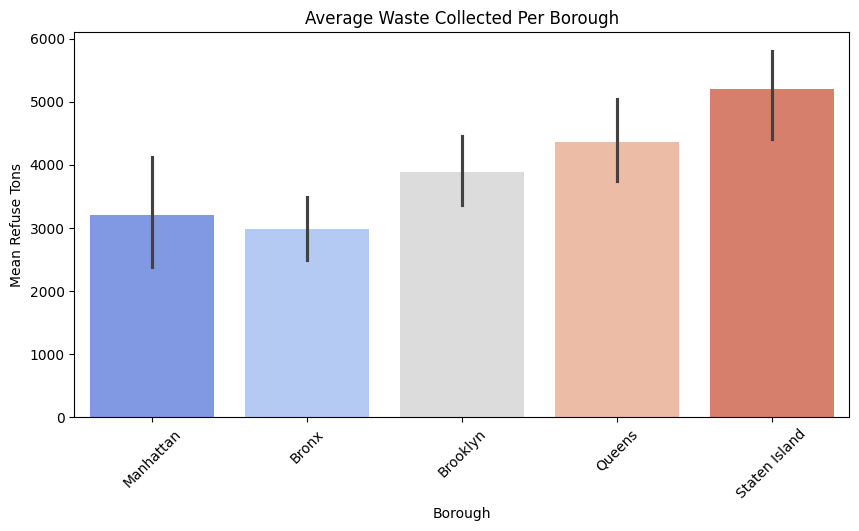

In [ ]:
# Plot total waste collection per borough
#import seaborn as sns
#import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=bins_per_comm, x="borough_name", y="mean(refuse_tons)", palette="coolwarm")
plt.title("Average Waste Collected Per Borough")
plt.ylabel("Mean Refuse Tons")
plt.xlabel("Borough")
plt.xticks(rotation=45)
plt.show()

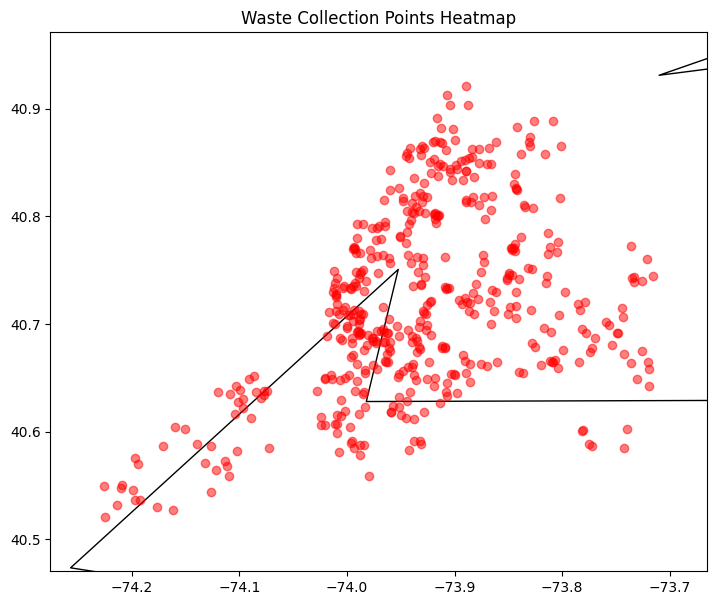

In [ ]:
# collection point
import geopandas as gpd

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(merged, geometry=gpd.points_from_xy(merged['longitude'], merged['latitude']))

# Plot Heatmap
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
fig, ax = plt.subplots(figsize=(10, 7))
world.plot(ax=ax, color="white", edgecolor="black")
gdf.plot(ax=ax, color="red", alpha=0.5)

min_x, max_x = gdf['longitude'].min() - .05, gdf['longitude'].max() + .05
min_y, max_y = gdf['latitude'].min() - .05, gdf['latitude'].max() + .05

ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)

plt.title("Waste Collection Points Heatmap")
plt.show()

#kafka

In [ ]:
model_json = lstm_model.to_json()
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)